In [40]:
# Packages

import pandas as pd
import os
import numpy as np
import mne
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
import pytz

import glob
import matplotlib.pyplot as plt
import seaborn as sns


In [41]:
# Helper functions
def unpack_edf(edf_path):
        
    base = os.path.basename(edf_path)  
    name, _ = os.path.splitext(base)
    out_csv = "data/bishkek_csr/nasal_files/" + f"{name}_csv.csv"

    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose='ERROR')

    ch_names = raw.ch_names
    data     = raw.get_data()              
    times    = raw.times                
    
    df = pd.DataFrame(data.T, columns=ch_names)
    df.insert(0, 'time_s', times)
        
    df.to_csv(out_csv, index=False)
    print(f"Saved {df.shape[0]} samples × {df.shape[1]} channels to '{out_csv}'")
    return df

def remove_col(file, col_name):
    df = pd.read_csv(file)
    df = df.drop(col_name, axis=1)
    df.to_csv(file, index=False)


In [42]:

# Functions to fix time stamp issues
def add_timestamp_export(csv_path: str, tz_name: str = 'Asia/Bishkek') -> None:
    """
    Reads a CSV file with a 'Time' column in 'DD.MM.YYYY HH:MM:SS' format,
    localizes each datetime to the specified timezone, computes a 'UnixTimestamp'
    column (seconds since epoch), inserts it immediately after the 'Duration' column,
    and overwrites the original file.
    
    Parameters
    ----------
    csv_path : str
        Path to the CSV file to read and overwrite.
    tz_name : str, optional
        Timezone name (default: 'Asia/Bishkek').
    """
    df = pd.read_csv(csv_path)
    tz = pytz.timezone(tz_name)
    dt_series = pd.to_datetime(df['Time'], format='%d.%m.%Y %H:%M:%S', dayfirst=True)
    dt_series = dt_series.dt.tz_localize(tz)
    ts_series = (dt_series.astype('int64') // 10**9).astype(int)
    duration_idx = df.columns.get_loc('Duration') 
    df.insert(duration_idx + 1, 'UnixTimestamp', ts_series)

    df.to_csv(csv_path, index=False)



def add_timestamp_comments(csv_path: str, date_str: str, tz_name: str = 'Asia/Bishkek') -> None:
    """
    Reads a CSV file with a 'Time' column in 'HH:MM:SS' format (and other columns),
    combines each time with the provided date (YYYY-MM-DD), localizes to the specified
    timezone, computes a 'UnixTimestamp' column (seconds since epoch), inserts it 
    immediately after the 'Time' column, and overwrites the original file.
    
    Parameters
    ----------
    csv_path : str
        Path to the CSV file to read and overwrite.
    date_str : str
        Date string in 'YYYY-MM-DD' format to combine with each time.
    tz_name : str, optional
        Timezone name (default: 'Asia/Bishkek').
    """
    # Load CSV
    df = pd.read_csv(csv_path)
    tz = pytz.timezone(tz_name)
    dt_series = pd.to_datetime(date_str + ' ' + df['Time'], format='%Y-%m-%d %H:%M:%S')
    dt_series = dt_series.dt.tz_localize(tz)
    ts_series = (dt_series.astype('int64') // 10**9).astype(int)
    time_idx = df.columns.get_loc('Time')
    df.insert(time_idx + 1, 'UnixTimestamp', ts_series)
    df.to_csv(csv_path, index=False)


def add_timestamp_nasal(
    csv_path: str,
    start_datetime_str: str,
    tz_name: str = "Asia/Bishkek"
) -> None:
    """
    Reads a CSV whose first column is elapsed time in seconds (float or int) named arbitrarily,
    adds that many seconds onto the given start_datetime_str (YYYY-MM-DD HH:MM:SS),
    localizes to the specified timezone, computes Unix timestamps, and inserts them right
    after the elapsed‐seconds column. Finally, overwrites the CSV in place.

    Parameters
    ----------
    csv_path : str
        Path to the CSV file to read and overwrite.
    start_datetime_str : str
        The starting point (date + time) in 'YYYY-MM-DD HH:MM:SS' format.
        This should already be in the Bishkek zone (UTC+6).
    tz_name : str, optional
        Timezone name (default: 'Asia/Bishkek').
    """
    df = pd.read_csv(csv_path)

    elapsed_col = df.columns[0]

    tz = pytz.timezone(tz_name)

    base_dt_naive = pd.to_datetime(start_datetime_str, format="%Y-%m-%d %H:%M:%S")
    base_dt = tz.localize(base_dt_naive)
    elapsed_td = pd.to_timedelta(df[elapsed_col], unit="s")

    dt_series = base_dt + elapsed_td
    unix_series = (dt_series.view("int64") // 10**9).astype(int)
    insert_idx = 1 
    df.insert(insert_idx, "UnixTimestamp", unix_series)
    df.to_csv(csv_path, index=False)

In [43]:
# Analysis: 
data_path = "../../data/bishkek_csr/02_intermediate/event_exports" # Make sure this path is correct
all_files = glob.glob(os.path.join(data_path, "*.csv"))
df_list = []
for filename in all_files:
    try:
        temp_df = pd.read_csv(filename)
        # Optional: Add a column to identify the source file if dates are important for distinction
        temp_df['source_file'] = os.path.basename(filename)
        # Optional: Extract date from filename if needed for analysis across days
        # For example, if filename is '04-04-2025_event_export.csv'
        # temp_df['date'] = os.path.basename(filename).split('_')[0]
        df_list.append(temp_df)
    except Exception as e:
        print(f"Error loading {filename}: {e}")

if not df_list:
    print("No data files found or loaded. Please check the path and file format.")
    # Exit or handle error appropriately
else:
    df = pd.concat(df_list, ignore_index=True)
    print(f"Successfully loaded {len(all_files)} files into a DataFrame with {df.shape[0]} rows and {df.shape[1]} columns.")
    print(df.head())


Successfully loaded 9 files into a DataFrame with 10525 rows and 11 columns.
      Event Stage                 Time Duration  UnixTimestamp  \
0  Hypopnea  n.a.  26.04.2025 01:32:23     11,6     1745609543   
1  Hypopnea  n.a.  26.04.2025 01:37:36     29,8     1745609856   
2  Hypopnea  n.a.  26.04.2025 01:38:18     23,4     1745609898   
3  Hypopnea  n.a.  26.04.2025 01:38:54     14,4     1745609934   
4  Hypopnea  n.a.  26.04.2025 01:39:23     18,2     1745609963   

          Position     Validation                  source_file Start Method  \
0  Position Supine  validated (M)  26-04-2025_event_export.csv   NaN    NaN   
1  Position Supine  not validated  26-04-2025_event_export.csv   NaN    NaN   
2  Position Supine  not validated  26-04-2025_event_export.csv   NaN    NaN   
3  Position Supine  not validated  26-04-2025_event_export.csv   NaN    NaN   
4  Position Supine  not validated  26-04-2025_event_export.csv   NaN    NaN   

   Duration [ms]  
0            NaN  
1            

In [44]:
if 'df' in locals(): # Check if df was created
    print("\n--- Basic Info ---")
    df.info()

    print("\n--- First 5 Rows ---")
    print(df.head())

    print("\n--- Missing Values (Count) ---")
    print(df.isnull().sum())

    print("\n--- Missing Values (Percentage) ---")
    print((df.isnull().sum() / len(df)) * 100)

    print("\n--- Duplicate Rows ---")
    print(f"Number of duplicate rows: {df.duplicated().sum()}")



--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10525 entries, 0 to 10524
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Event          10525 non-null  object 
 1   Stage          6116 non-null   object 
 2   Time           6116 non-null   object 
 3   Duration       9416 non-null   object 
 4   UnixTimestamp  10525 non-null  int64  
 5   Position       6116 non-null   object 
 6   Validation     6116 non-null   object 
 7   source_file    10525 non-null  object 
 8   Start          4409 non-null   object 
 9   Method         4409 non-null   object 
 10  Duration [ms]  1109 non-null   float64
dtypes: float64(1), int64(1), object(9)
memory usage: 904.6+ KB

--- First 5 Rows ---
      Event Stage                 Time Duration  UnixTimestamp  \
0  Hypopnea  n.a.  26.04.2025 01:32:23     11,6     1745609543   
1  Hypopnea  n.a.  26.04.2025 01:37:36     29,8     1745609856   
2  Hypopnea  n.

In [45]:
if 'UnixTimestamp' in df.columns:
    df['datetime'] = pd.to_datetime(df['UnixTimestamp'], unit='s') # Change 's' to 'ms' if it's milliseconds
    print("\n--- Converted UnixTimestamp to Datetime ---")
    print(df[['UnixTimestamp', 'datetime']].head())
    # You can now extract components:
    df['hour_of_day'] = df['datetime'].dt.hour
    df['day_of_week'] = df['datetime'].dt.day_name() # If your timestamps span multiple days correctly
    df['date_only'] = df['datetime'].dt.date


--- Converted UnixTimestamp to Datetime ---
   UnixTimestamp            datetime
0     1745609543 2025-04-25 19:32:23
1     1745609856 2025-04-25 19:37:36
2     1745609898 2025-04-25 19:38:18
3     1745609934 2025-04-25 19:38:54
4     1745609963 2025-04-25 19:39:23



--- Event Distribution ---
Event
Phase shift                4522
Pulse variance             1779
PWArousal (spontaneous)    1619
Hypopnea                    956
Desaturation                510
Obstructive Apnea           473
PWArousal (respiratory)     417
Obstructive Hypopnea         85
RERA                         74
Artifact                     34
Light off                    28
Snoring                      19
Central Apnea                 4
Cheyne-Stokes                 2
Mixed Apnea                   2
Light on                      1
Name: count, dtype: int64

--- Event Distribution (Percentage) ---
Event
Phase shift                42.964371
Pulse variance             16.902613
PWArousal (spontaneous)    15.382423
Hypopnea                    9.083135
Desaturation                4.845606
Obstructive Apnea           4.494062
PWArousal (respiratory)     3.961995
Obstructive Hypopnea        0.807601
RERA                        0.703088
Artifact                    0.323040
Light off  

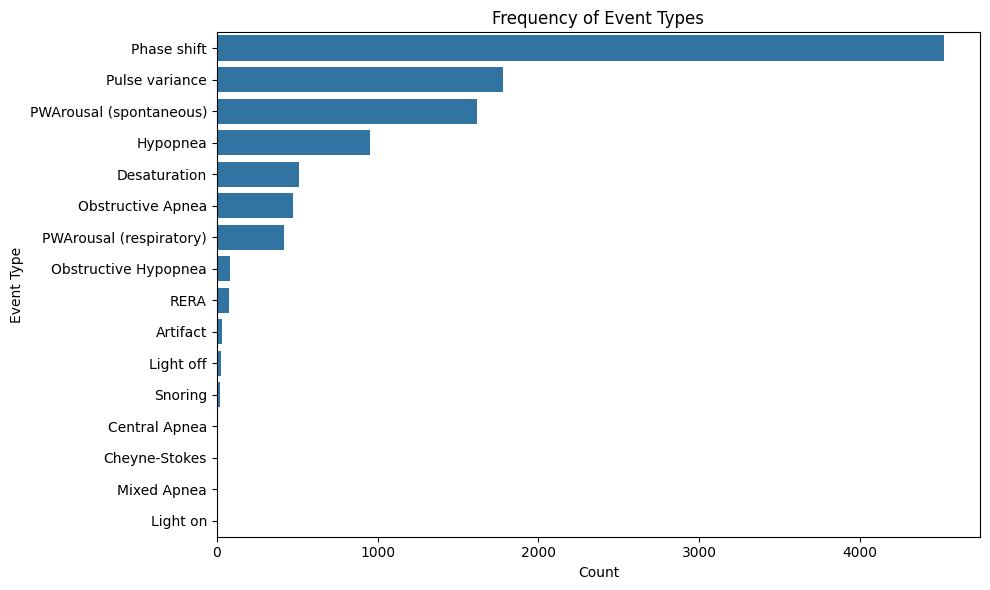

In [46]:
if 'Event' in df.columns:
    print("\n--- Event Distribution ---")
    event_counts = df['Event'].value_counts()
    print(event_counts)
    print("\n--- Event Distribution (Percentage) ---")
    print(df['Event'].value_counts(normalize=True) * 100)

    plt.figure(figsize=(10, 6))
    sns.countplot(y='Event', data=df, order=event_counts.index) # Horizontal for better label readability
    plt.title('Frequency of Event Types')
    plt.xlabel('Count')
    plt.ylabel('Event Type')
    plt.tight_layout()
    plt.show()
    # Note any class imbalance.